# Get Data

Data -> PubMed 200k RCT dataset.

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 44.98 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the Dataset "PubMed_20k_RCT"
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k dataset no numbers
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [5]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads file and returns the lines of text as a list

  Args:
    filename: a string containg the target filepath

  Returns:
    A list of strings with one string per line from the target file
  """

  with open(filename, "r") as f:
    return f.readlines()

In [6]:
# Lets read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Transform the file into a list of dictionaries:

```
[{"line_number": 0,
  "target": "BACKGROUND",
  "text": "text_line",
  "total_lines": 11,},
  ...]
```




In [7]:
def preprocess_text(filename):
  """
  Retruns a list of dictionaries of abstract line data

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are the current abstract and what sentence
  number the raget line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_line = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if tthe it is an ID line
      abstract_id = line
      abstract_line = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if it is a new line
      abstract_line_split = abstract_line.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split tag from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get text
        line_data["line_number"] = abstract_line_number # line index
        line_data["total_lines"] = len(abstract_line_split) - 1 # Total lines (it starts from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the condicions aren't fulfilled, the line containes a labelled sentence
      abstract_line += line
  return abstract_samples

In [8]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text(data_dir+"train.txt")
val_samples = preprocess_text(data_dir+"dev.txt")
test_samples = preprocess_text(data_dir+"test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 620 ms, sys: 112 ms, total: 732 ms
Wall time: 896 ms


In [9]:
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

### Visualize data

In [10]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Distribution of labels in train data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

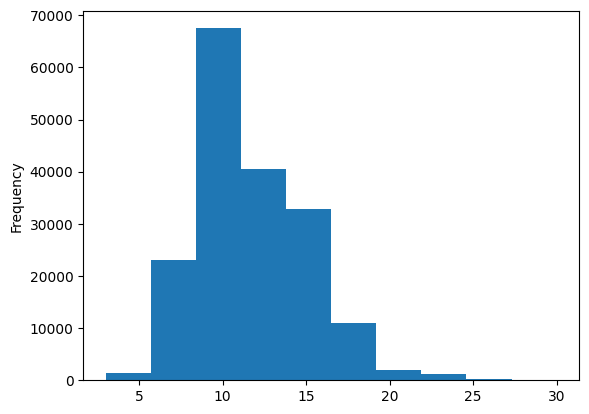

In [12]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [14]:
# Visualize 10 lines
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [15]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False) # non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [16]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# Get classes names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments

### Model 0: Baseline (TF_IDF Multinomial Naive Bayes Classifier)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
# EValuate basline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [20]:
# Make some predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
  """
  Calculates model accuracy, precision, recall and f1-score

  Returns:
    Sample of 5 predictions, and scores (accuracy, precision, recall and f1-score)

  """

  #Get model predictions
  y_preds_probs = model.predict(X_test) # Get model predictions

  # Logic to use this function with model_0 and other experiments
  if y_preds_probs.ndim == 1:
    y_preds = y_preds_probs
  else:
    y_preds = tf.argmax(y_preds_probs, axis=1) # Transform pred probs in integers

  print(f"Predictions sample: {y_preds[:5]}\n") # Check predictions

  # Calculate accuracy
  model_accuracy = accuracy_score(y_test, y_preds)

  # Calculate precision, recall and f1-score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test, y_preds, average="weighted")

  # Save in a dictionary
  model_score = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1_score": model_f1}

  return model_score

In [23]:
model_0.predict(val_sentences).ndim

1

In [24]:
baseline_results = evaluate_model(model=model_0,
                                  X_test=val_sentences,
                                  y_test=val_labels_encoded)

Predictions sample: [4 1 3 2 2]



## Preparing our data for deep sequence models

In [25]:
# How long is each sentence
sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_sen_len = np.mean(sentence_len)
avg_sen_len

26.338269273494777

(array([7.3163e+04, 8.1733e+04, 1.8772e+04, 4.5680e+03, 1.2400e+03,
        3.5400e+02, 1.1600e+02, 4.5000e+01, 1.7000e+01, 1.2000e+01,
        1.2000e+01, 3.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.        ,  20.66666667,  40.33333333,  60.        ,
         79.66666667,  99.33333333, 119.        , 138.66666667,
        158.33333333, 178.        , 197.66666667, 217.33333333,
        237.        , 256.66666667, 276.33333333, 296.        ]),
 <BarContainer object of 15 artists>)

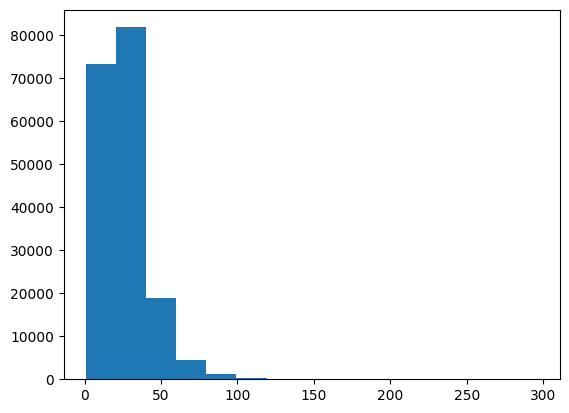

In [26]:
# What's the distribution look like
import matplotlib.pyplot as plt
plt.hist(sentence_len, bins=15)

In [27]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sentence_len, 95))
output_seq_len

55

In [28]:
# Max sequence length
max(sentence_len)

296

### Create text vectorizer layers

In [29]:
# Words in vocab
max_tokens =  68000

In [30]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # length of vectorized sequences

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {[text_vectorizer([target_sentence])]}")

Text:
 outcome variables included the percentage of patients with good agreement with physician-derived swollen joints -lsb- prevalence-adjusted bias-adjusted kappa ( pabak ) > @ -rsb- as well as agreement in the sjc ( bland and altman @ % limits of agreement ) , feasibility/patient satisfaction survey and disease activity at @ months .

Length of text: 52

Vectorized text: [<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   86,   498,   121,     2,   467,     4,    12,     7,   745,
         1407,     7, 49003,  6592,  3153,    46, 48047, 62811,  4155,
        35968,    45,    25,   221,    25,  1407,     5,     2, 16550,
        15165,     3, 17560,  2798,     4,  1407, 57923,   428,   885,
            3,   114,   190,    15,    41,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>]


In [33]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Creating custom text embedding

In [35]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [36]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 outcome variables included the percentage of patients with good agreement with physician-derived swollen joints -lsb- prevalence-adjusted bias-adjusted kappa ( pabak ) > @ -rsb- as well as agreement in the sjc ( bland and altman @ % limits of agreement ) , feasibility/patient satisfaction survey and disease activity at @ months .

Sentence after vectorization (before embedding):
 [[   86   498   121     2   467     4    12     7   745  1407     7 49003
   6592  3153    46 48047 62811  4155 35968    45    25   221    25  1407
      5     2 16550 15165     3 17560  2798     4  1407 57923   428   885
      3   114   190    15    41     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.03002983  0.0067663   0.04586852 ... -0.01483192 -0.04468084
    0.0007235 ]
  [ 0.00832118 -0.00728521 -0.00425567 ... -0.00097015 -0.04813845
    0.00483199]
  [-0.04961435 -0.00364996  0.00436433 ... -0.014

## Creating datasets (making sure our data loads as fast as possible)

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSlicesDatasets and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token ebeddings

In [39]:
# Create 1D conv model to preocess sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(54, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 54)            34614     
                                                                 
 global_average_pooling1d (  (None, 54)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [40]:
# Fit model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 58s 81ms/step - loss: 0.9171 - accuracy: 0.6415 - val_loss: 0.6924 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.6616 - accuracy: 0.7547 - val_loss: 0.6253 - val_accuracy: 0.7739
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.6188 - accuracy: 0.7725 - val_loss: 0.5976 - val_accuracy: 0.7806


In [41]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.5992 - accuracy: 0.7856


[0.5992426872253418, 0.7855818867683411]

In [42]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 5s 5ms/step


(array([[4.2562667e-01, 1.9921267e-01, 7.6462120e-02, 2.6431578e-01,
         3.4382790e-02],
        [4.1310722e-01, 3.2569245e-01, 1.2447039e-02, 2.4053806e-01,
         8.2152495e-03],
        [1.5716220e-01, 1.0837654e-02, 2.7011319e-03, 8.2922798e-01,
         7.0993126e-05],
        ...,
        [4.1719713e-06, 6.3201477e-04, 6.0185522e-04, 1.5730320e-06,
         9.9876034e-01],
        [5.6162503e-02, 4.9831909e-01, 9.4415180e-02, 6.6222563e-02,
         2.8488067e-01],
        [1.9046395e-01, 5.9347916e-01, 5.7581905e-02, 6.8779066e-02,
         8.9695975e-02]], dtype=float32),
 (30212, 5))

In [43]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
# Calculate model_1 results
model_1_results = evaluate_model(model=model_1,
                                 X_test=val_sentences,
                                 y_test=val_labels_encoded)

model_1_results

945/945 [==============================] - 2s 2ms/step
Predictions sample: [0 0 3 2 4]



{'accuracy': 0.7855818879915265,
 'precision': 0.781835265170699,
 'recall': 0.7855818879915265,
 'f1_score': 0.7827067265568248}

## Model 2: Feature extraction with pretrained token embeddings

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [45]:
# Download pretrained Tensoflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [46]:
# Test out the pretrained embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_training_sentence}")
use_embeddeding_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embeddeding_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embeddeding_sentence[0])}")

Random sentence:
 in addition , patients scored changes of general complaints using cox retrospective symptom scales ( rss-cox ) and @-point verbal rating scale ( vrs ) during three menstrual cycles .
Sentence after embedding:
[-0.00579018  0.03028451 -0.0220033  -0.01437998  0.06666625  0.0294637
  0.03199852  0.00248908 -0.00187745  0.0532917   0.07832924 -0.00444317
  0.01844008  0.07133642  0.04822208 -0.03659099 -0.07533813 -0.06960312
  0.00052974  0.04473016  0.01767197  0.06260902 -0.07289943  0.05549553
 -0.03384878  0.05896361  0.05267967 -0.00972189  0.02220751  0.05522939]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [47]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize and create embedding of each text sequence
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [48]:
# Fit model_2
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 15ms/step - loss: 0.9121 - accuracy: 0.6516 - val_loss: 0.7972 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7695 - accuracy: 0.6997 - val_loss: 0.7557 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 13s 24ms/step - loss: 0.7538 - accuracy: 0.7124 - val_loss: 0.7393 - val_accuracy: 0.7158


In [49]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7423 - accuracy: 0.7123


[0.7423391342163086, 0.7123328447341919]

In [50]:
# Evaluate model with the function
model_2_results = evaluate_model(model=model_2,
                                 X_test=val_sentences,
                                 y_test=val_labels_encoded)
model_2_results

945/945 [==============================] - 19s 20ms/step
Predictions sample: [0 1 3 2 4]



{'accuracy': 0.7123328478750165,
 'precision': 0.7130795924402951,
 'recall': 0.7123328478750165,
 'f1_score': 0.7092911839506817}

In [51]:
model_1_results

{'accuracy': 0.7855818879915265,
 'precision': 0.781835265170699,
 'recall': 0.7855818879915265,
 'f1_score': 0.7827067265568248}

In [52]:
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

### Creating a char-level tokenizer

In [53]:
# Make a function to split sentences into charactes
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-characters-level sequence into charaters
split_chars(random_training_sentence)

'i n   a d d i t i o n   ,   p a t i e n t s   s c o r e d   c h a n g e s   o f   g e n e r a l   c o m p l a i n t s   u s i n g   c o x   r e t r o s p e c t i v e   s y m p t o m   s c a l e s   (   r s s - c o x   )   a n d   @ - p o i n t   v e r b a l   r a t i n g   s c a l e   (   v r s   )   d u r i n g   t h r e e   m e n s t r u a l   c y c l e s   .'

In [54]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [55]:
# Whats's the average character length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_chars_len = np.mean(chars_lens)
mean_chars_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

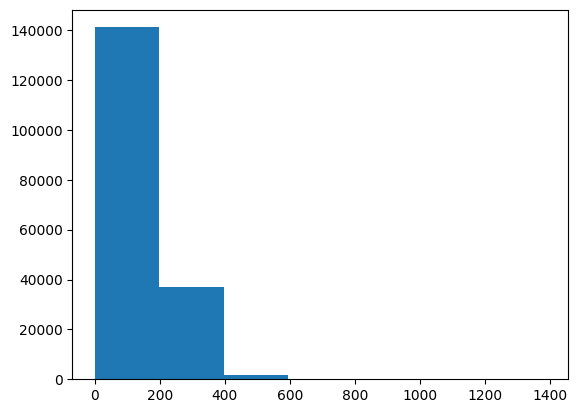

In [56]:
# Check the distribution of our sequence at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=7)

In [57]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [58]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
# Create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [60]:
# Adapt character vectorizer to training caracters
char_vectorizer.adapt(train_chars)

In [61]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [62]:
# Test out char vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vetorized chars: {len(vectorized_chars[0])}")

Charified text:
 w e   i n v e s t i g a t e d   t h e   e f f e c t s   o f   a   @ - h o u r   i n t r a v e n o u s   g l p - @   i n f u s i o n   o n   t h e   i g f   s y s t e m   i n   @   o v e r n i g h t   f a s t e d   h e a l t h y   h u m a n s   ,   u s i n g   a   r a n d o m i z e d   ,   d o u b l e - b l i n d e d   ,   c r o s s - o v e r   s t u d y   d e s i g n   .

Length of random_train_chars: 157

Vectorized chars:
 [[20  2  4  6 21  2  9  3  4 18  5  3  2 10  3 13  2  2 17 17  2 11  3  9
   7 17  5 13  7 16  8  4  6  3  8  5 21  2  6  7 16  9 18 12 14  4  6 17
  16  9  4  7  6  7  6  3 13  2  4 18 17  9 19  9  3  2 15  4  6  7 21  2
   8  6  4 18 13  3 17  5  9  3  2 10 13  2  5 12  3 13 19 13 16 15  5  6
   9 16  9  4  6 18  5  8  5  6 10  7 15  4 25  2 10 10  7 16 22 12  2 22
  12  4  6 10  2 10 11  8  7  9  9  7 21  2  8  9  3 16 10 19 10  2  9  4
  18  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  

## Creating a character-level embedding

In [63]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, #char size of the char embedding in the original paper
                              mask_zero=True,
                              name="char_embedding")

In [64]:
# Test our character embedding layer
print(f"Charifies text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and emvedding:\n {char_embed_example})\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charifies text:
 w e   i n v e s t i g a t e d   t h e   e f f e c t s   o f   a   @ - h o u r   i n t r a v e n o u s   g l p - @   i n f u s i o n   o n   t h e   i g f   s y s t e m   i n   @   o v e r n i g h t   f a s t e d   h e a l t h y   h u m a n s   ,   u s i n g   a   r a n d o m i z e d   ,   d o u b l e - b l i n d e d   ,   c r o s s - o v e r   s t u d y   d e s i g n   .

Embedded chars. (after vectorization and emvedding:
 [[[ 0.04358191  0.03693542  0.00896119 ... -0.00605414 -0.0055207
   -0.03475804]
  [-0.00577798 -0.00178375  0.01799745 ...  0.04566645 -0.02550329
    0.01964868]
  [-0.00783626 -0.04111906 -0.0161838  ... -0.00201583 -0.01629144
   -0.02823738]
  ...
  [ 0.03102816  0.01638527 -0.02804151 ...  0.00241812 -0.01330675
   -0.03257573]
  [ 0.03102816  0.01638527 -0.02804151 ...  0.00241812 -0.01330675
   -0.03257573]
  [ 0.03102816  0.01638527 -0.02804151 ...  0.00241812 -0.01330675
   -0.03257573]]])

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [65]:
# Conv1D on chars
inputs = layers.Input(shape=(1,), dtype=("string"))
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=10, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv_1D_char_embeddings")

# Compile
model_3.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary
model_3.summary()

Model: "model_3_conv_1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           16064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None,

In [66]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)) .batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)) .batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)) .batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [67]:
history = model_3.fit(train_char_dataset,
                      steps_per_epoch=int(0.1 * len(train_char_dataset)),
                      epochs=3,
                      validation_data=val_char_dataset,
                      validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 1.2088 - accuracy: 0.5072 - val_loss: 0.9785 - val_accuracy: 0.6220
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9349 - accuracy: 0.6322 - val_loss: 0.8593 - val_accuracy: 0.6792
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.8478 - accuracy: 0.6737 - val_loss: 0.7965 - val_accuracy: 0.6935


In [68]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.18577348, 0.51656073, 0.07517387, 0.20075113, 0.02174078],
       [0.17197081, 0.4486034 , 0.00636176, 0.35995713, 0.01310683],
       [0.07507956, 0.03608547, 0.01834541, 0.8665129 , 0.00397659],
       ...,
       [0.00306163, 0.02044799, 0.0285837 , 0.00346188, 0.94444484],
       [0.03564499, 0.09108517, 0.53161466, 0.04212226, 0.2995329 ],
       [0.5238613 , 0.3251745 , 0.09062783, 0.05698662, 0.00334974]],
      dtype=float32)

In [69]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

In [70]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1_score": model_f1}
  return model_results

In [71]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 0.6911492122335496,
 'precision': 0.6859982685008302,
 'recall': 0.6911492122335496,
 'f1_score': 0.6840069002797501}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding)

Steps:
1. Create a token-level embedding model (similar to "model_1")
2. Create a character-level model (similar to model_3)
3. Combine 1 and 2 with a concatenate layer.
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the original paper
5. Build a model wich takes token and character-level sequences as input and produces sequence label probabilities as output

In [72]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers -> adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Build model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [73]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

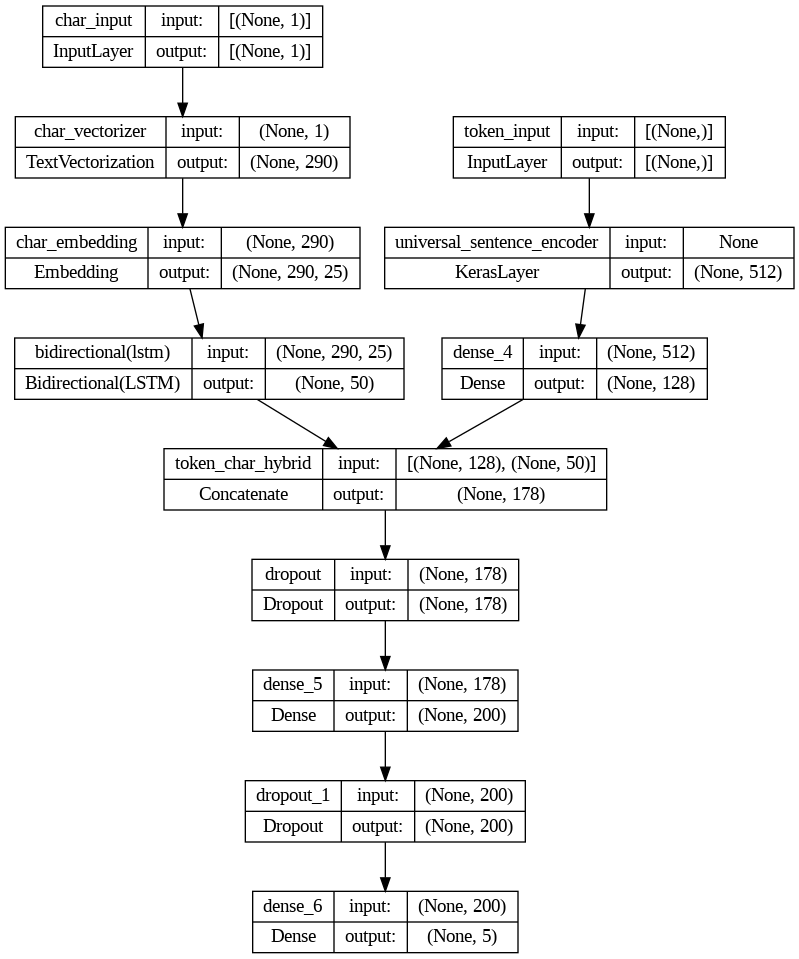

In [74]:
# Plot hybrid token and char model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [75]:
# Compile model
model_4.compile(loss="CategoricalCrossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

### Combining token and character daata into a tf.data Dataset

In [76]:
# Combine chars and token into a dataset (train)
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip(train_char_token_data, train_char_token_labels) # combine data and labels

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Combine chars and token into a dataset (val)
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip(val_char_token_data, val_char_token_labels) # combine data and labels

# prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
# Check our training and token embedding dataset
train_char_token_dataset, val_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and char-level seuences

In [78]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                             steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                             epochs=3,
                             validation_data=val_char_token_dataset,
                             validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 55s 68ms/step - loss: 0.9687 - accuracy: 0.6177 - val_loss: 0.7782 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7949 - accuracy: 0.6904 - val_loss: 0.7127 - val_accuracy: 0.7281
Epoch 3/3
562/562 [==============================] - 33s 59ms/step - loss: 0.7649 - accuracy: 0.7057 - val_loss: 0.6910 - val_accuracy: 0.7370


In [79]:
# Evaluate on the whole val dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6961 - accuracy: 0.7338


[0.6961451172828674, 0.7338143587112427]

In [80]:
# Make preds
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 18ms/step


array([[4.2214543e-01, 3.5695320e-01, 4.5118555e-03, 2.1033290e-01,
        6.0566757e-03],
       [3.0956310e-01, 4.9779049e-01, 3.5429737e-03, 1.8769102e-01,
        1.4124872e-03],
       [2.8275368e-01, 1.6300388e-01, 8.3841562e-02, 4.1453922e-01,
        5.5861671e-02],
       ...,
       [7.2778657e-04, 1.1436808e-02, 4.7452193e-02, 2.1530961e-04,
        9.4016796e-01],
       [5.4510375e-03, 8.1226304e-02, 1.6007195e-01, 2.2940787e-03,
        7.5095659e-01],
       [2.8362176e-01, 3.8548827e-01, 2.4456236e-01, 3.4294397e-02,
        5.2033216e-02]], dtype=float32)

In [81]:
# Format into labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [82]:
# get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 0.7338143783926916,
 'precision': 0.7359651187806224,
 'recall': 0.7338143783926916,
 'f1_score': 0.7313235622516937}

In [83]:
model_1_results

{'accuracy': 0.7855818879915265,
 'precision': 0.781835265170699,
 'recall': 0.7855818879915265,
 'f1_score': 0.7827067265568248}

## Model 5: Same as model 4 + positional embeddings

In [84]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**NOTE:** Engineered features used to train a model need to be available at test time

### Create positional embeddings

In [85]:
# How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

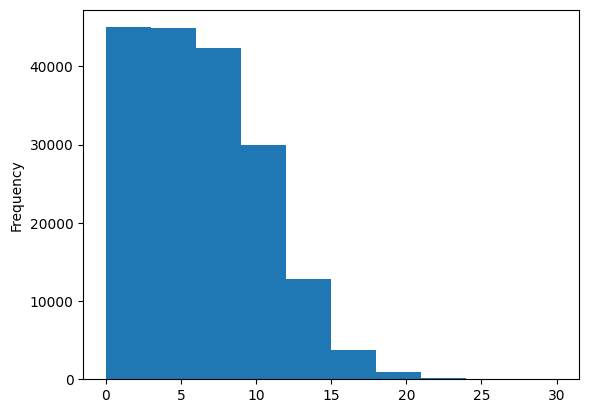

In [86]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [87]:
# Create one-hot-encoded tensors of "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [88]:
# How many different total lines are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

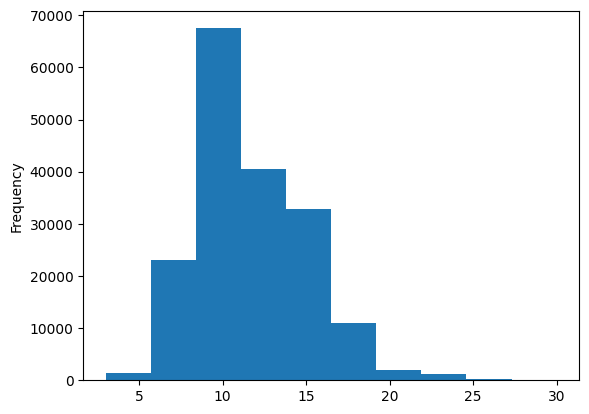

In [89]:
# Check the distribution of "total_lines" column
train_df.total_lines.plot.hist()

In [90]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a tf.keras.Model

In [91]:
# 1. Create tokem inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Create a character-level inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Create a model for the line_number
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Create a model fot the total_lines
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char models
combined_embeddings = layers.Concatenate(name="char_token_hybrid")([token_model.output,
                                                                    char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine line number, total lines and the hybrid embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                total_lines_model.output,
                                                                                z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Assemble the model
model_5 = tf.keras.Model(inputs=[line_number_model.input, # Order is important
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")

In [92]:
# Get a summary
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_

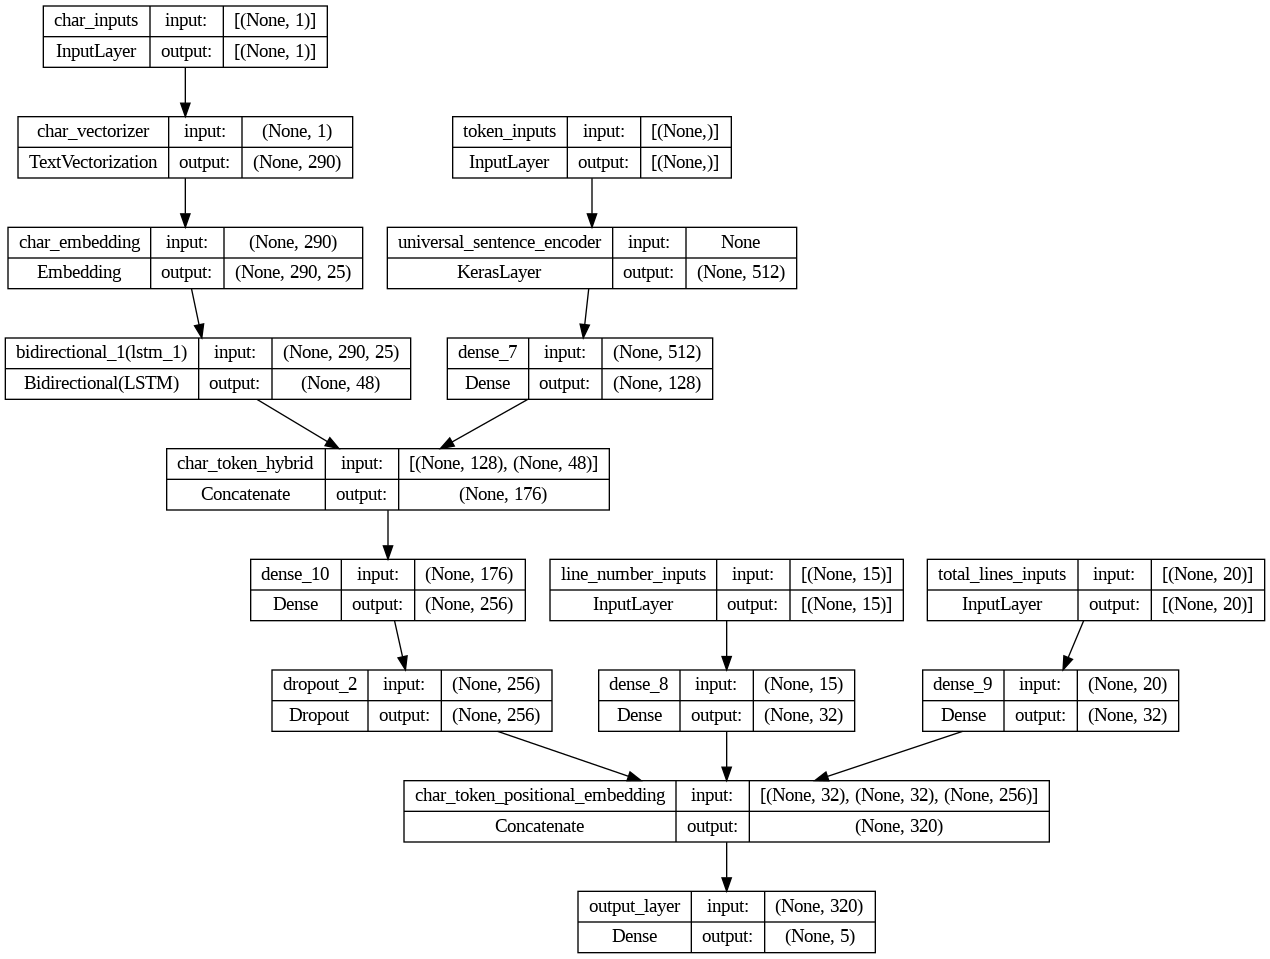

In [93]:
plot_model(model_5, show_shapes=True)

In [94]:
# Copile model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating tribrid embedding datasets using tf.data

In [95]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation set
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
# Check input shapes
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with the tribrid model


In [97]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(train_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 49s 69ms/step - loss: 1.0985 - accuracy: 0.7207 - val_loss: 0.9782 - val_accuracy: 0.8020
Epoch 2/3
562/562 [==============================] - 45s 80ms/step - loss: 0.9679 - accuracy: 0.8181 - val_loss: 0.9474 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 32s 57ms/step - loss: 0.9501 - accuracy: 0.8222 - val_loss: 0.9332 - val_accuracy: 0.8352


In [98]:
# Make predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 22s 19ms/step


array([[0.49667552, 0.11337591, 0.01150339, 0.36158764, 0.01685761],
       [0.57598656, 0.0990821 , 0.04390744, 0.27192372, 0.00910028],
       [0.29952648, 0.11546522, 0.1367224 , 0.37438536, 0.07390051],
       ...,
       [0.03490598, 0.09156635, 0.03454779, 0.02860878, 0.81037104],
       [0.03163379, 0.2826482 , 0.07436327, 0.02979869, 0.5815561 ],
       [0.21618138, 0.6044143 , 0.09139001, 0.03494733, 0.05306695]],
      dtype=float32)

In [99]:
# Convert pred probs into labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [100]:
# Calculate results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 0.8329802727393089,
 'precision': 0.8321937656270286,
 'recall': 0.8329802727393089,
 'f1_score': 0.8318531821415894}

### Compare model results

In [101]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"Baseline:": baseline_results,
                                 "Model_1:": model_1_results,
                                 "Model_2:": model_2_results,
                                 "Model_3:": model_3_results,
                                 "Model_4:": model_4_results,
                                 "Model_5:": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1_score
Baseline:,0.721832,0.718647,0.721832,0.698925
Model_1:,0.785582,0.781835,0.785582,0.782707
Model_2:,0.712333,0.713080,0.712333,0.709291
Model_3:,0.691149,0.685998,0.691149,0.684007
Model_4:,0.733814,0.735965,0.733814,0.731324
Model_5:,0.832980,0.832194,0.832980,0.831853


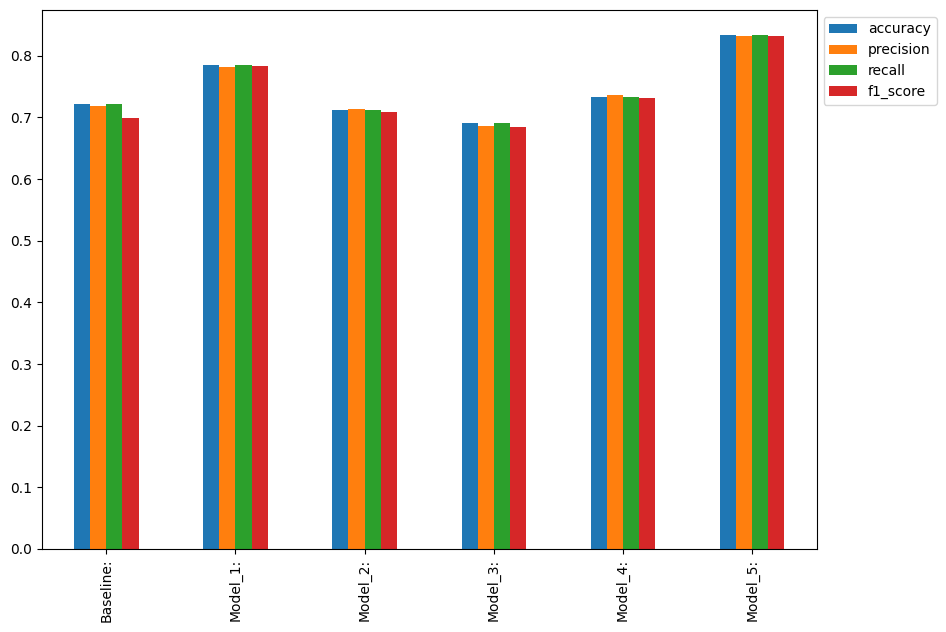

In [102]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

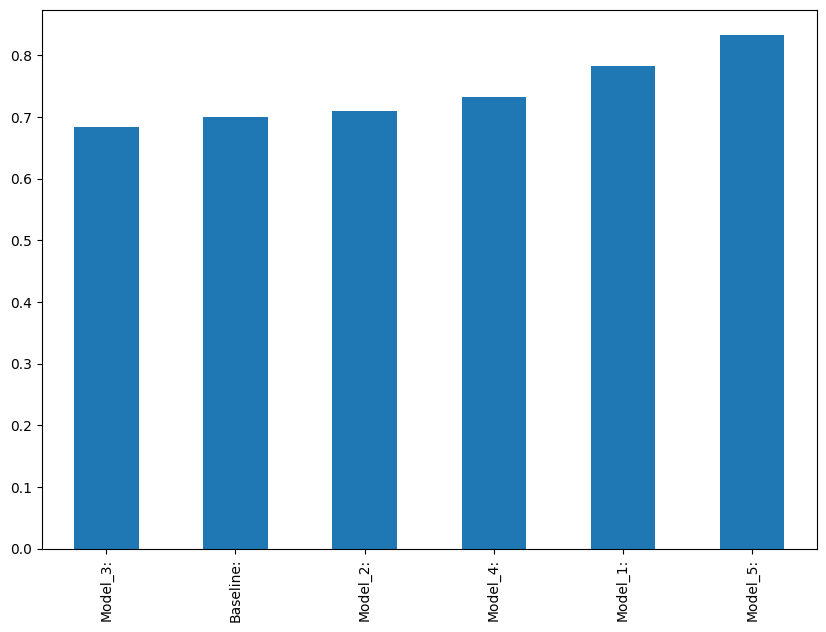

In [104]:
# Sort models results by f1_score
all_model_results.sort_values("f1_score", ascending=True)["f1_score"].plot(kind="bar", figsize=(10, 7));

## Save and load model

In [105]:
# Save the best performing model
model_5.save("skimlit_tribrid_model")

In [106]:
# Load the model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [107]:
# Make preds
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 26s 25ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [108]:
# Calculate results
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 0.8329802727393089,
 'precision': 0.8321937656270286,
 'recall': 0.8329802727393089,
 'f1_score': 0.8318531821415894}

In [110]:
loaded_model_results == model_5_results

True